In [1]:
#!pip install chembl_downloader pandas numpy

In [11]:
# 1) ChEMBL: fetch + query
#from chembl_downloader import download_extract_sqlite, connect

sqlite_path = download_extract_sqlite(version=35)  # or your chosen version
# 20 min runtime for download_extract_sqlite

In [15]:
import sqlite3, pandas as pd, numpy as np

def column_exists(con, table, col):
    return any(r[1] == col for r in con.execute(f"PRAGMA table_info({table})"))

with sqlite3.connect(str(sqlite_path)) as con:
    # pick the right column name for this dump
    tgt_id_col = "chembl_id" if column_exists(con, "target_dictionary", "chembl_id") else "target_chembl_id"

    q = f"""
    SELECT a.activity_id, a.assay_id, a.standard_type, a.standard_relation,
           a.standard_value, a.standard_units, a.pchembl_value,
           cs.canonical_smiles, a.molregno,
           s.tid, td.{tgt_id_col} AS target_chembl_id, td.pref_name AS target_name
    FROM activities a
    JOIN assays s               ON a.assay_id = s.assay_id
    JOIN compound_structures cs ON a.molregno = cs.molregno
    JOIN target_dictionary td   ON s.tid = td.tid
    WHERE a.data_validity_comment IS NULL
      AND a.standard_units = 'nM'
      AND a.standard_relation = '='
      AND a.standard_type IN ('Kd','Ki','IC50');
    """

    chembl_df = pd.read_sql_query(q, con)

# compute pAff (fallback if pchembl_value is null)
chembl_df["pAff"] = pd.to_numeric(chembl_df["pchembl_value"], errors="coerce")
mask = chembl_df["pAff"].isna() & chembl_df["standard_value"].notna()
chembl_df.loc[mask, "pAff"] = -np.log10(pd.to_numeric(chembl_df.loc[mask, "standard_value"], errors="coerce") * 1e-9)

# (optional) basic sanity checks
print(chembl_df[["standard_type","standard_units","pAff"]].head())
print("Rows:", len(chembl_df), "| Null pAff:", chembl_df["pAff"].isna().sum())


  standard_type standard_units  pAff
0          IC50             nM  5.60
1          IC50             nM  5.05
2          IC50             nM  5.40
3          IC50             nM  4.77
4          IC50             nM  6.75
Rows: 2457811 | Null pAff: 728


In [16]:
print(sqlite_path)


C:\Users\khcod\.data\chembl\35\chembl_35.db


# Light GBM Baseline Notes

Training Data Overview

Dataset source: curated ChEMBL bioactivity data (≈150 K high-confidence Kd / Ki / IC₅₀ records).

Target variable: pAff = −log₁₀(binding constant in M) → higher = stronger binding.

Samples used for training: ~120 K rows per fold (5-fold CV).

Features per molecule: **1,032 total**:

1,024 bits: Morgan circular fingerprint (radius = 2) → encodes substructure patterns.

8 continuous descriptors: molecular weight, log P, TPSA, H-bond donors/acceptors, rotatable bonds, ring count, formal charge.

Feature type: all numeric/tabular → ideal for tree-based boosting.

Model: LightGBM Regressor

Algorithm: Gradient Boosting Decision Trees (histogram-based).

Objective: reg:squarederror → minimize mean-squared error on pAff.

Key hyperparameters

| Parameter                 | Purpose                       | Value / Rationale                                        |
| ------------------------- | ----------------------------- | -------------------------------------------------------- |
| `n_estimators`            | # of boosting rounds          | 2000 → ensures convergence under early-stopping          |
| `learning_rate`           | step size per tree            | 0.03 → stable gradient updates                           |
| `max_depth`               | tree depth                    | 6 → controls model complexity, avoids overfit            |
| `num_leaves`              | (implied) leaf count per tree | ≈ 31 (default) → balances expressivity vs generalization |
| `subsample`               | row sampling per tree         | 0.8 → adds stochasticity, reduces variance               |
| `colsample_bytree`        | feature sampling per tree     | 0.8 → reduces correlation among trees                    |
| `reg_alpha`, `reg_lambda` | L1 / L2 regularization        | 1e-3 / 1.0 → limits overfitting                          |
| `n_jobs`                  | threads                       | auto-detected → parallelized training                    |



## Diagnostics

120 K ligands × 1 K features trained with a shallow-tree LightGBM ensemble (depth 6, η 0.03, subsample 0.8) delivers a strong baseline pAffinity predictor with interpretable feature importances and good runtime efficiency on CPU

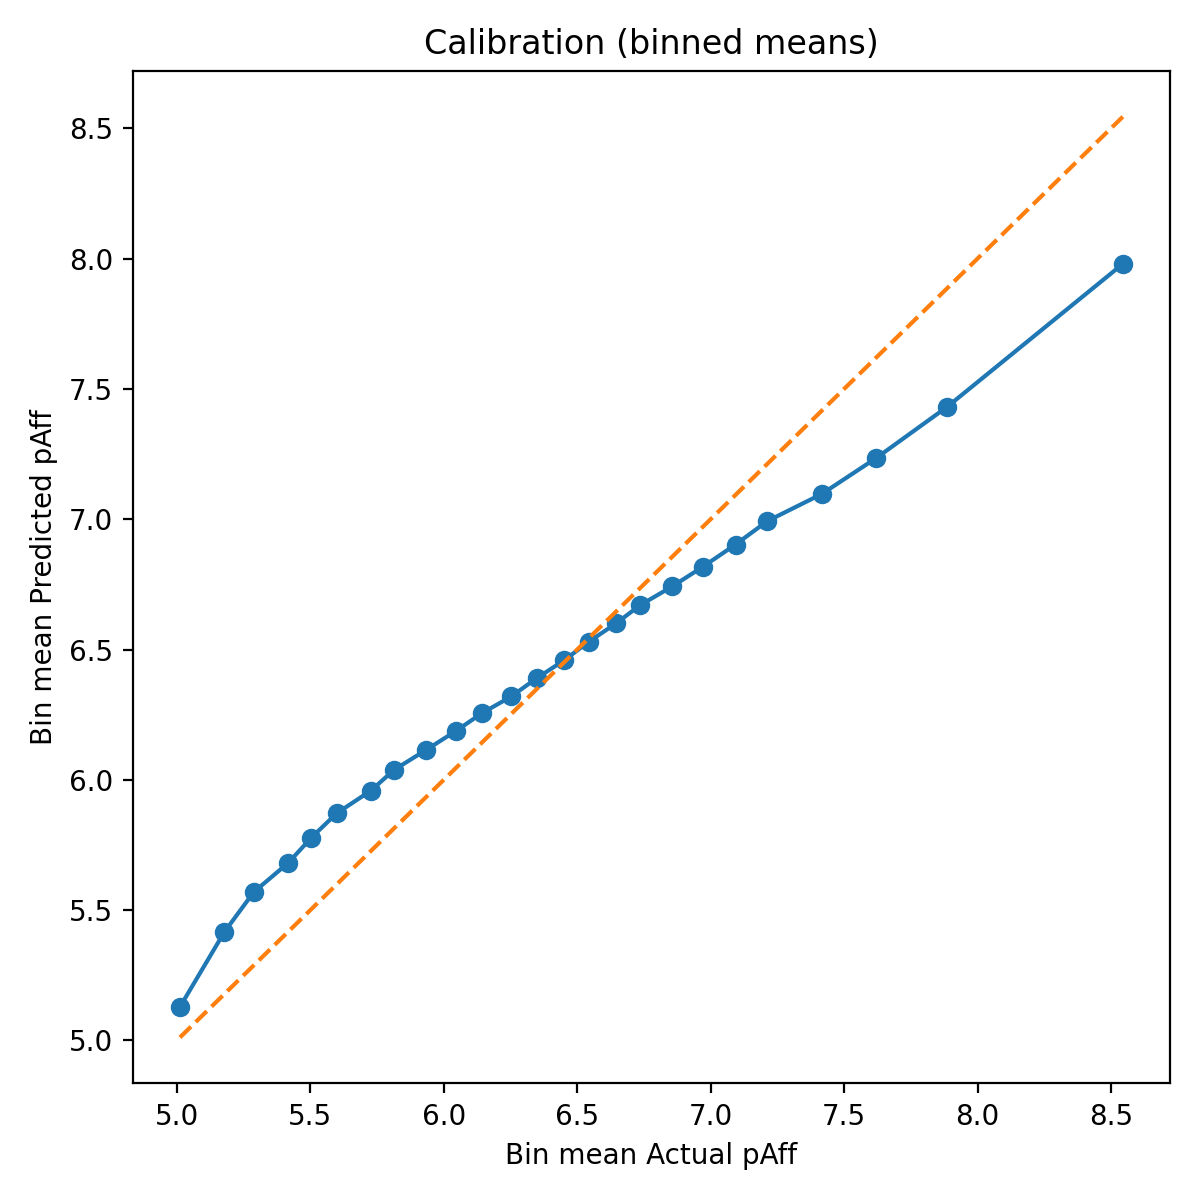

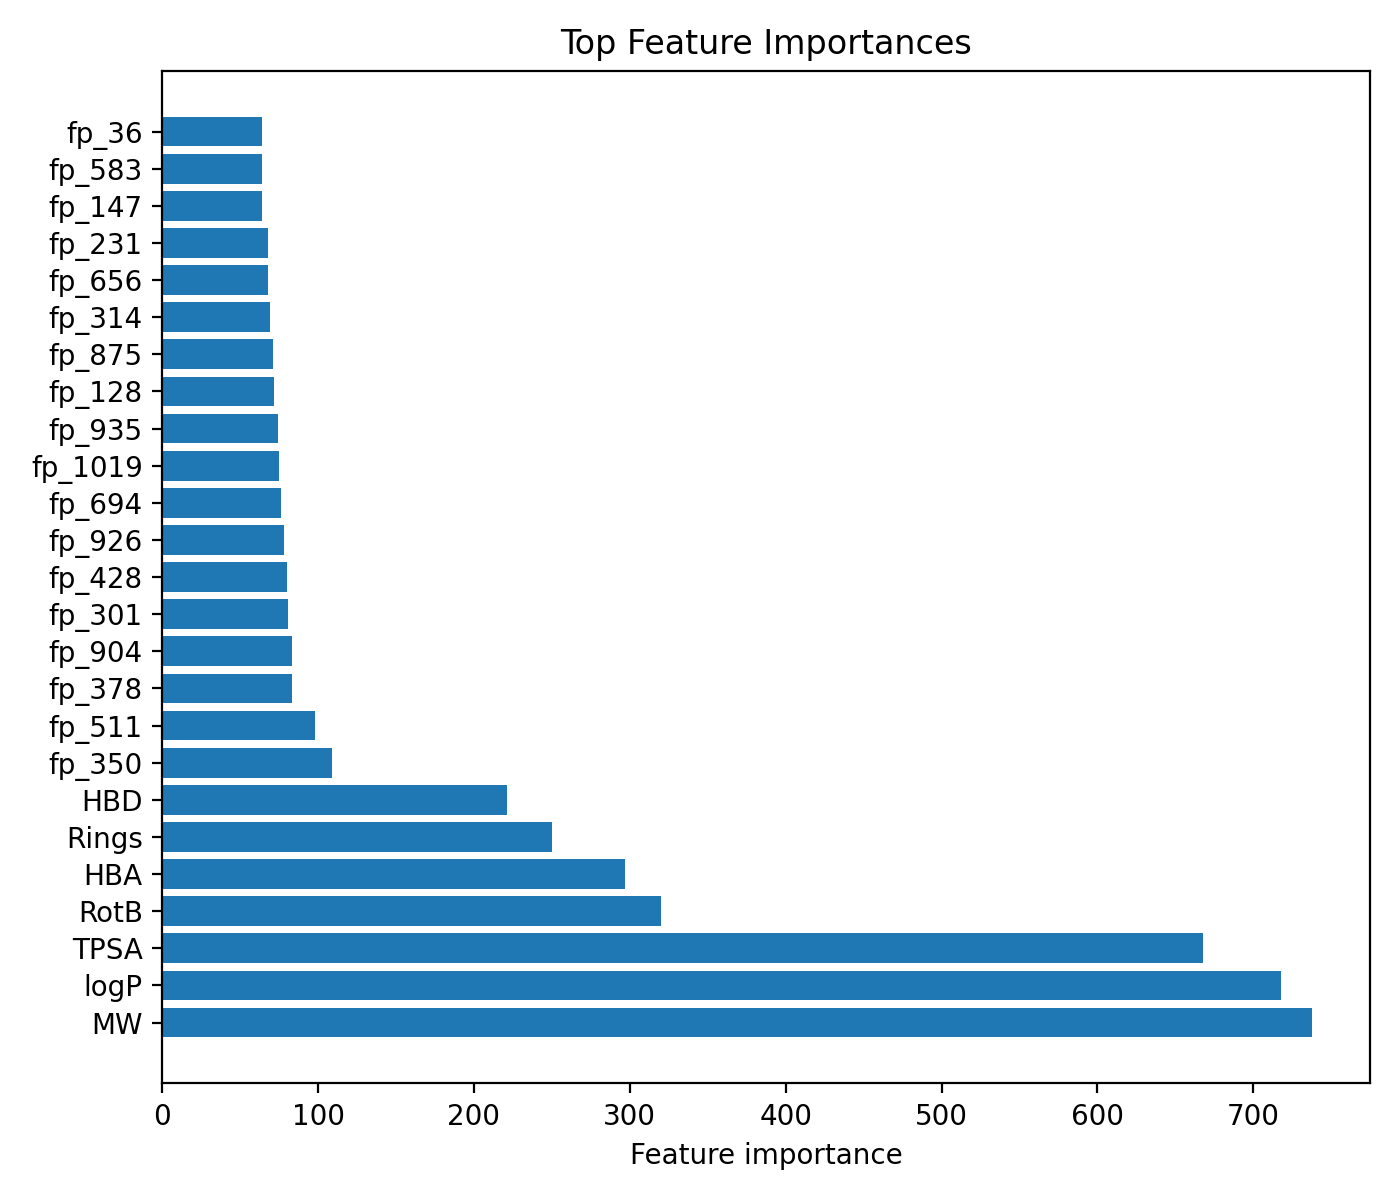

Without protein or 3D pocket information, the model can only capture:

intrinsic ligand properties (hydrophobicity, size, H-bond counts),

statistical biases in ChEMBL data (drug-like molecules tend to bind in a certain pKd range).

## Feature Importance

Molecular Weight as expected by binding laws, logP (hydrophobicity), TPSA (Topological Polar Surface Area) H-bonding potential, RotB (freely rotating single bonds), HBA (H-bond acceptors), HBD (H-bond Donors), Rings (aromatic+aliphatic), encodings of Morgan Fingerprint structures (local chemical motifs like amines).

## Next Steps

currently overestimating weak binders and underestimating strong binders. *Protein-specific* binding will require 3D features/protein-specific embeddings - PDBBind

### Group Thoughts

Graph NNs, CNNs, and many other model architectures address protein-ligand binding in contemporary lit. What is our rationale for Boosting? This baseline proves that it can work. However, are we aiming for *novelty, interpretability, or accuracy* for **Aim 1**?

Are highly dimensional Morgan Fingerprint encodings necessary? Or, do they add unnecessary model complexity by adding > 1000 parameters (Or more intense L1 regularization to feature select).

For future models, best way to collaborate? GitHub optimal if we can share GPU clusters.

## Kent **TO DO** for Aim 1

- 